In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
import pickle
from string import punctuation

!pip install pymystem3
from pymystem3 import Mystem

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/food-com-recipes-and-user-interactions/interactions_train.csv
/kaggle/input/food-com-recipes-and-user-interactions/ingr_map.pkl
/kaggle/input/food-com-recipes-and-user-interactions/interactions_test.csv
/kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv
/kaggle/input/food-com-recipes-and-user-interactions/interactions_validation.csv
/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv
/kaggle/input/food-com-recipes-and-user-interactions/PP_users.csv


In [43]:
recipes=pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv',
                   converters={'tags': lambda x: x[1:-1].replace('"', '').replace("'", "").replace(" ", "").split(',')}
                   )

recipes["Text"] = recipes["name"] + ' ' + recipes["description"]
recipes = recipes.drop(['id', 'minutes','contributor_id', 'nutrition', 'n_steps', 'n_ingredients', 'submitted', 'name', 'description', 'steps', 'ingredients'], axis=1)
recipes.head()

,tags,Text
0,"[60-minutes-or-less, time-to-make, course, mai...",arriba baked winter squash mexican style aut...
1,"[30-minutes-or-less, time-to-make, course, mai...",a bit different breakfast pizza this recipe c...
2,"[time-to-make, course, preparation, main-dish,...",all in the kitchen chili this modified versio...
3,"[60-minutes-or-less, time-to-make, course, mai...","alouette potatoes this is a super easy, great..."
4,"[weeknight, time-to-make, course, main-ingredi...",amish tomato ketchup for canning my dh's ami...


In [44]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text)
    text = re.sub("," , " ", text)
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    return text

recipes.Text = recipes.Text.fillna(" no recipe ")
recipes.Text = recipes.Text.apply(lambda x: clean_text(x))
recipes.Text[2]

'all in the kitchen chili this modified version of moms chili was a hit at our christmas party we made an extra large pot to have some left to freeze but it never made it to the freezer it was a favorite by all perfect for any cold and rainy day you wont find this one in a cookbook it is truly an original'

In [45]:
#from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
recipes = recipes.join(pd.DataFrame(mlb.fit_transform(recipes.pop('tags')),
                          columns=mlb.classes_,
                          index=recipes.index))
recipes.head()

,Text,,1-day-or-more,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,60-minutes-or-less,ThrowtheultimatefiestawiththissopaipillasrecipefromFood.com.,...,whitefish,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini
0,arriba baked winter squash mexican style autum...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,a bit different breakfast pizza this recipe ca...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,all in the kitchen chili this modified version...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,alouette potatoes this is a super easy great t...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,amish tomato ketchup for canning my dhs amish ...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


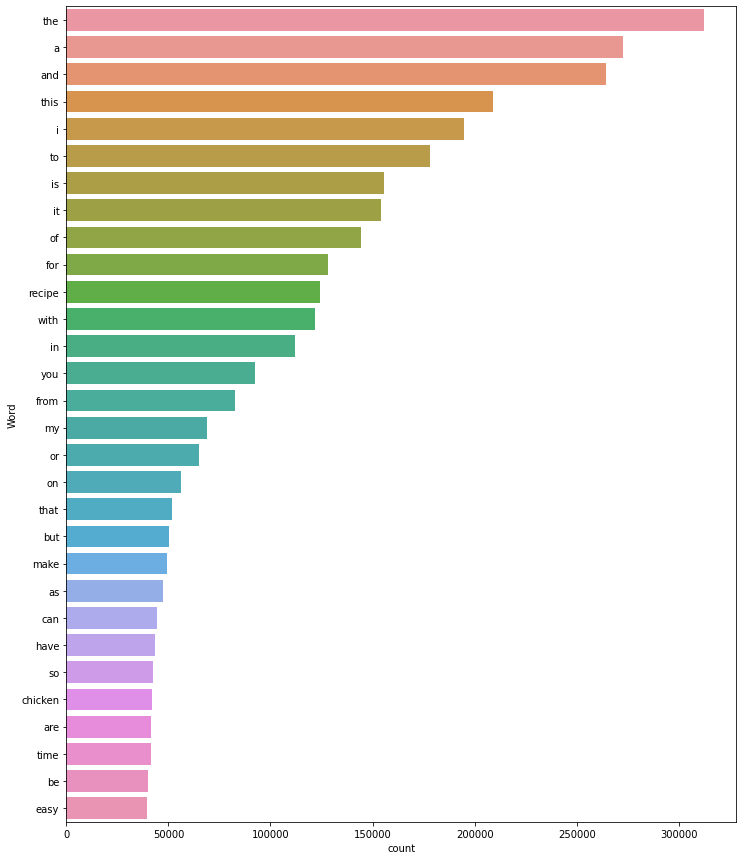

In [46]:
def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()
  
  #print 100 most frequent words 
freq_words(recipes.Text, 30)

In [47]:
mystem = Mystem() 
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token != " " \
              and token.strip() not in punctuation]    
    text = " ".join(tokens)
    return text

recipes.Text = recipes.Text.apply(preprocess_text)

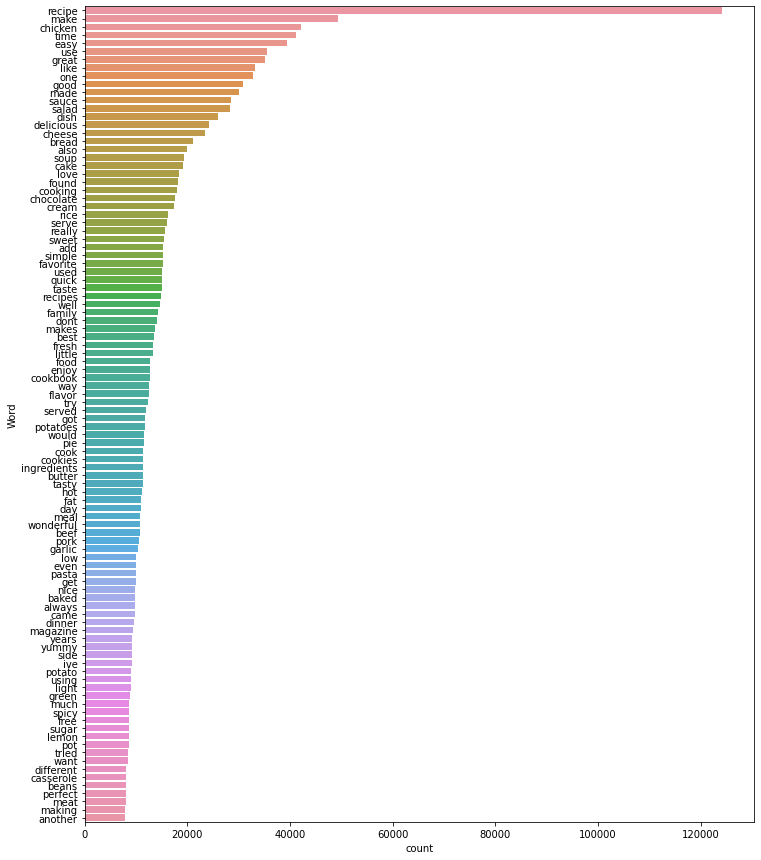

In [48]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

recipes.Text = recipes.Text.apply(lambda x: remove_stopwords(x))

freq_words(recipes.Text, 100)

In [56]:
from sklearn.preprocessing import MultiLabelBinarizer

#multilabel_binarizer = MultiLabelBinarizer()
#multilabel_binarizer.fit(recipes.tags)

# transform target variable
y = recipes.drop(['Text'], axis=1)

In [50]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [61]:
xtrain, xval, ytrain, yval = train_test_split(recipes.Text, y, test_size=0.2, random_state=9)

In [62]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [63]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [65]:
lr = LogisticRegression(max_iter = 1000)
clf = OneVsRestClassifier(lr)
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 59 is present in all training examples.
  str(classes[c]))
/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 62 is present in all training examples.
  str(classes[c]))
/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 64 is present in all training examples.
  str(classes[c]))
/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 74 is present in all training examples.
  str(classes[c]))
/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 152 is present in all training examples.
  str(classes[c]))
/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 153 is present in all training examples.
  str(classes[c]))
/opt/conda/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 159 is present in all traini

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [66]:
y_pred = clf.predict(xval_tfidf)

In [ ]:
#y_pred[3]

In [67]:
multilabel_binarizer.inverse_transform(y_pred)[3]

NotFittedError: This MultiLabelBinarizer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
#f1_score(yval, y_pred, average="micro")

In [ ]:
def infer_tags(q):
    q = clean_text(q)
    q = preprocess_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

infer_tags('fried chicken')

In [ ]:
#recipes_mini=recipes.head(3)
#recipes_mini.head()

In [ ]:
#

In [ ]:
def converter(x):
    return frozenset(x) if isinstance(x, (set, list)) else x

#print(len(mini.tags.apply(converter).unique()))